## Prediccion: Online

Exponer el modelo y obtener las predicciones

## Webservice en local

In [ ]:
!mlflow models serve --model-uri models:/extratree/Production -p 8001

## Webservice en Docker

In [ ]:
cmd_build = f'mlflow models build-docker -m {model_path} -n {name}'
logs_build_image = subprocess.check_output(cmd_build.split())

In [36]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from cl.checker import check_drift


@check_drift
def predicting(filename, host, port):
    with mlflow.start_run(run_name='predicting') as mlrun:

        X_inference = pd.read_csv(filename).head(10)
        data = X_inference.to_json(orient='split')

        response = requests.post(
            url="{host}:{port}/invocations".format(host=host, port=port),
            data=data,
            headers={"Content-Type": "application/json"},
        )
        print(response.text)

        if response.status_code != 200:
            raise Exception(
                "Status Code {status_code}. {text}".format(
                    status_code=response.status_code, text=response.text
                )
            )

        predictions = response.text
        # print(predictions[:5])
        with open('predictions.npy', 'wb') as f:
            np.save(f, predictions)
        mlflow.log_artifact('predictions.npy')
        
        return predictions

In [37]:
filename = "preprocessed_data.csv"
predictions = predicting(filename, model_name="extratree", model_version=4)

[19:44:17] Check drift passed successfully                                     ]8;id=590495;file:///home/jovyan/cl/checker.py\checker.py]8;;\:]8;id=190949;file:///home/jovyan/cl/checker.py#128\128]8;;\

           Running 'predicting'                                                ]8;id=694309;file:///home/jovyan/cl/checker.py\checker.py]8;;\:]8;id=606154;file:///home/jovyan/cl/checker.py#129\129]8;;\

Loading model: extratree:4


           Finished 'predicting' in 0.0991 secs                                ]8;id=299295;file:///home/jovyan/cl/checker.py\checker.py]8;;\:]8;id=753922;file:///home/jovyan/cl/checker.py#134\134]8;;\

In [38]:
predictions[:5]

array([32, 11, 12,  9,  1])

[ 1  5  7  8  9 10 11 12 13 14 24 27 28 29 31 32 34 36]


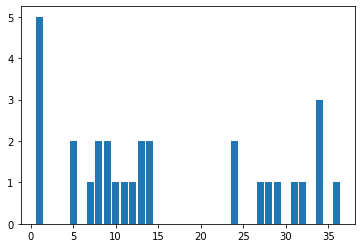

In [39]:
unique, counts = np.unique(predictions, return_counts=True)
d = dict(zip(unique, counts))
plt.bar(*zip(*d.items()))

print(unique)
plt.show()

In [1]:
import pandas as pd
filename = "preprocessed_data.csv"
X_inference = pd.read_csv(filename)

In [2]:
X_inference.head()

,eccentricity,aspect_ratio,elongation,solidity,stochastic_convexity,isoperimetric_factor,maximal_indentation_depth,lobedness,average_intensity,average_contrast,smoothness,third_moment,uniformity,entropy
0,0.86224,2.0735,0.52269,0.98686,0.99474,0.70529,0.010097,0.018554,0.041404,0.121630,0.014579,0.004869,0.000276,0.94580
1,0.52382,1.1117,0.67175,0.54701,0.62982,0.15157,0.136740,3.402800,0.026434,0.085792,0.007306,0.002137,0.000166,0.90513
2,0.82866,1.9848,0.50917,0.94180,0.99825,0.55942,0.025524,0.118570,0.080103,0.166920,0.027107,0.008655,0.000427,1.80380
3,0.70668,1.2510,0.38111,0.94226,0.99825,0.69250,0.019432,0.068724,0.031587,0.115020,0.013056,0.005311,0.000086,0.72247
4,0.73935,1.5319,0.34987,0.98479,1.00000,0.81067,0.007808,0.011095,0.027888,0.114720,0.012990,0.006017,0.000050,0.59895


In [5]:
list(X_inference.columns)

['eccentricity',
 'aspect_ratio',
 'elongation',
 'solidity',
 'stochastic_convexity',
 'isoperimetric_factor',
 'maximal_indentation_depth',
 'lobedness',
 'average_intensity',
 'average_contrast',
 'smoothness',
 'third_moment',
 'uniformity',
 'entropy']

In [14]:
X_inference.head(1).values.tolist()

[[0.86224,
  2.0735,
  0.52269,
  0.98686,
  0.99474,
  0.70529,
  0.010097,
  0.018554,
  0.041404,
  0.12163,
  0.014579,
  0.0048689,
  0.00027608,
  0.9458]]

!curl http://127.0.0.1:8001/invocations -H 'Content-Type: application/json' -d '{ "columns": list(X_inference.columns), "data": X_inference.head(1).values.tolist() }'

In [23]:
import requests

host = '0.0.0.0'
port = '8001'

url = f'http://{host}:{port}/invocations'

headers = {
    'Content-Type': 'application/json',
}

# test_data is a Pandas dataframe with data for testing the ML model
test_data = X_inference.head(10)
http_data = test_data.to_json(orient='split')

r = requests.post(url=url, headers=headers, data=http_data)

print(f'Predictions: {r.text}')

Predictions: [32, 11, 12, 9, 1, 1, 36, 27, 13, 29]
